# Day 3-4: First Probes - Sentiment Detection

**Goal:** Build hands-on probe expertise through sentiment classification

**Learning Objectives:**
1. Train your first probe on transformer activations
2. Compare probe performance across layers
3. Test generalization and identify failure modes
4. Understand spurious correlations

**Timeline:** 8-10 hours

---

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import transformer_lens as tl

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"TransformerLens ready!")

c:\Users\ndcm1133\OneDrive - Nexus365\Desktop\AI_Safety_Projects\AI-safety-research\mech_interp_env_py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1+cpu
CUDA available: False
TransformerLens ready!


In [2]:
# Load GPT-2 small
model = tl.HookedTransformer.from_pretrained("gpt2-small")
print(f"Model loaded: {model.cfg.n_layers} layers, {model.cfg.d_model} dimensions")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
Model loaded: 12 layers, 768 dimensions


---

## Part 1: Basic Sentiment Probe (2 hours)

**Concept:** Can we train a probe to detect sentiment from layer activations?

**Hypothesis:** If sentiment information is linearly accessible at layer 6, a simple logistic regression should achieve >70% accuracy.

In [13]:
# Dataset: Positive and negative sentences
positive_sentences = [
    "I love this movie!",
    "This is amazing and wonderful!",
    "Great job, fantastic work!",
    "I absolutely loved every minute of that film.",
    "This is the best coffee I've ever tasted.",
    "She was so kind and helpful throughout the process.",
    "What a beautiful day to be outside.",
    "I'm thrilled with how the project turned out.",
    "The team did an outstanding job on this.",
    "I can't wait to visit again next year.",
    "This restaurant exceeded all my expectations.",
    "He's such a talented and generous person.",
    "I feel incredibly grateful for this opportunity.",
    "The service here is always fantastic.",
    "That was the most fun I've had in ages.",
    "I'm so proud of what we accomplished together.",
    "This book changed my perspective completely.",
    "The sunset tonight was absolutely stunning.",
    "I've never felt more welcomed anywhere.",
    "Everything about this experience was delightful.",
    "She gave the most inspiring speech I've ever heard.",
    "I'm genuinely excited about what's next.",
    "This made my whole week better.",
]

negative_sentences = [
    "I hate this movie.",
    "This is terrible and awful.",
    "Poor job, disappointing work.",
    "I was deeply disappointed by the outcome.",
    "The food was cold and tasteless.",
    "This has been the worst customer service experience.",
    "I regret wasting my time on this.",
    "The whole event was a complete disaster.",
    "I'm frustrated with how poorly this was handled.",
    "Nothing about this met my expectations.",
    "The quality has really gone downhill.",
    "I felt completely ignored the entire time.",
    "This product broke after just one use.",
    "What a miserable waste of money.",
    "I've never been so let down by a company.",
    "The atmosphere was unpleasant and unwelcoming.",
    "I'm annoyed that nobody bothered to help.",
    "This ruined what should have been a good day.",
    "The wait was unbearable and unnecessary.",
    "I found the whole thing incredibly tedious.",
    "They clearly don't care about their customers.",
    "I'm upset that this turned out so badly.",
    "Everything that could go wrong did."
]

print(f"Dataset: {len(positive_sentences)} positive, {len(negative_sentences)} negative")

Dataset: 23 positive, 23 negative


### Extract Activations

**Key Decision:** Which token's activation should we use?
- **Last token:** Usually contains most information (what we'll start with)
- First token: Less information about sentence content
- Mean pooling: Average across all tokens

In [14]:
def get_final_token_activation(model, sentences, layer=6):
    """
    Extract activation of the final token at specified layer.
    
    Args:
        model: HookedTransformer model
        sentences: List of strings
        layer: Which layer to extract from (0-11 for GPT-2 small)
    
    Returns:
        numpy array of shape (n_sentences, d_model)
    """
    activations = []
    
    for sentence in sentences:
        # Run model and cache activations
        _, cache = model.run_with_cache(sentence)
        
        # Extract residual stream at specified layer
        # Shape: [batch=1, seq_len, d_model=768]
        layer_acts = cache["resid_post", layer]
        
        # Get final token's activation
        final_act = layer_acts[0, -1, :].cpu().numpy()
        activations.append(final_act)
    
    return np.array(activations)

# Test it
test_acts = get_final_token_activation(model, ["Test sentence"], layer=6)
print(f"Activation shape: {test_acts.shape}")  # Should be (1, 768)

Activation shape: (1, 768)


In [15]:
# Extract activations for our dataset at layer 6
print("Extracting activations... (this may take a minute)")

X_pos = get_final_token_activation(model, positive_sentences, layer=6)
X_neg = get_final_token_activation(model, negative_sentences, layer=6)

# Combine into single dataset
X = np.vstack([X_pos, X_neg])
y = np.array([1]*len(positive_sentences) + [0]*len(negative_sentences))

print(f"X shape: {X.shape}")  # (40, 768)
print(f"y shape: {y.shape}")  # (40,)
print(f"Class balance: {np.sum(y)} positive, {len(y) - np.sum(y)} negative")

Extracting activations... (this may take a minute)
X shape: (46, 768)
y shape: (46,)
Class balance: 23 positive, 23 negative


### Train the Probe

**What's happening:** Logistic regression learns a weight vector (direction in 768-dim space) that best separates positive from negative.

In [17]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 32, Test size: 14


In [ ]:
# Train the probe
probe = LogisticRegression(max_iter=1000, random_state=42)
probe.fit(X_train, y_train)

# Evaluate
train_acc = probe.score(X_train, y_train)
test_acc = probe.score(X_test, y_test)

print(f"\n=== Probe Performance ===")
print(f"Train accuracy: {train_acc:.2%}")
print(f"Test accuracy:  {test_acc:.2%}")
print(f"Train/test gap: {(train_acc - test_acc):.2%}")

# Detailed test set performance
y_pred = probe.predict(X_test)
print(f"\n{classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])}")


=== Probe Performance ===
Train accuracy: 100.00%
Test accuracy:  85.71%
Train/test gap: 14.29%

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86         7
    Positive       0.86      0.86      0.86         7

    accuracy                           0.86        14
   macro avg       0.86      0.86      0.86        14
weighted avg       0.86      0.86      0.86        14



### Reflection Questions

**Before moving on, think about:**
1. Is your test accuracy >70%? (Success criterion)
2. Is the train/test gap <15%? (Overfitting check)
3. What does this tell you about sentiment being linearly accessible at layer 6?

**Write your observations here:**
- The test accuracy is 85.71% which means that the probe is almost at the threshold for overfitting on the small dataset.
- The train/test gap is 14.29% which means that the probe is close to overfitting to the training dataset.
- This tells us that the sentiment is linearly accessible at layer 6.

---

## Part 2: Multi-Layer Comparison (2 hours)

**Question:** Which layer has the most accessible sentiment information?

**Hypothesis:** Later layers should be better (information gets refined as it flows through).

**Why this matters:** For CoT faithfulness, understanding WHERE in the model information crystallizes is crucial.

In [20]:
# Test multiple layers
layers_to_test = [0, 2, 4, 6, 8, 10, 11]
results = []

print("Testing multiple layers... (this will take a few minutes)\n")

for layer in layers_to_test:
    # Extract activations at this layer
    X_pos = get_final_token_activation(model, positive_sentences, layer=layer)
    X_neg = get_final_token_activation(model, negative_sentences, layer=layer)
    X = np.vstack([X_pos, X_neg])
    y = np.array([1]*len(positive_sentences) + [0]*len(negative_sentences))
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Train probe
    probe_layer = LogisticRegression(max_iter=1000, random_state=42)
    probe_layer.fit(X_train, y_train)
    
    # Evaluate
    train_acc = probe_layer.score(X_train, y_train)
    test_acc = probe_layer.score(X_test, y_test)
    
    results.append({
        'layer': layer,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'gap': train_acc - test_acc
    })
    
    print(f"Layer {layer:2d}: Train={train_acc:.2%}, Test={test_acc:.2%}, Gap={train_acc - test_acc:.2%}")

print("\nDone!")

Testing multiple layers... (this will take a few minutes)

Layer  0: Train=100.00%, Test=85.71%, Gap=14.29%
Layer  2: Train=100.00%, Test=85.71%, Gap=14.29%
Layer  4: Train=100.00%, Test=85.71%, Gap=14.29%
Layer  6: Train=100.00%, Test=85.71%, Gap=14.29%
Layer  8: Train=100.00%, Test=85.71%, Gap=14.29%
Layer 10: Train=100.00%, Test=92.86%, Gap=7.14%
Layer 11: Train=100.00%, Test=92.86%, Gap=7.14%

Done!


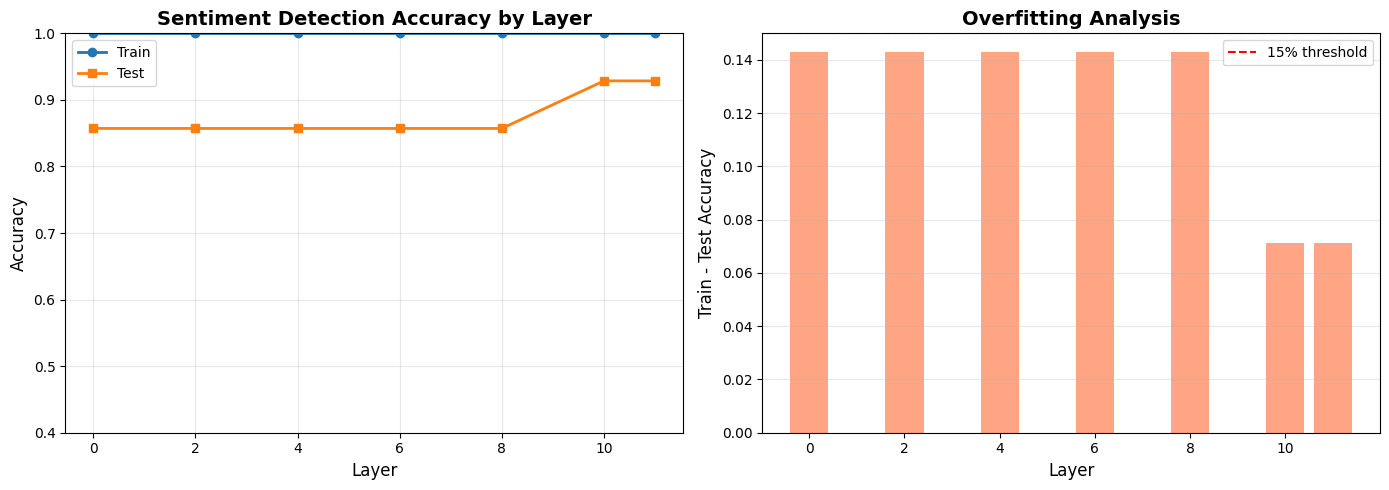


Best performing layer (test acc): Layer 10


In [21]:
# Visualize results
import pandas as pd

df_results = pd.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by layer
ax1.plot(df_results['layer'], df_results['train_acc'], marker='o', label='Train', linewidth=2)
ax1.plot(df_results['layer'], df_results['test_acc'], marker='s', label='Test', linewidth=2)
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Sentiment Detection Accuracy by Layer', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.4, 1.0])

# Plot 2: Train/test gap
ax2.bar(df_results['layer'], df_results['gap'], color='coral', alpha=0.7)
ax2.axhline(y=0.15, color='red', linestyle='--', label='15% threshold')
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Train - Test Accuracy', fontsize=12)
ax2.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('sentiment_probe_layer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest performing layer (test acc): Layer {df_results.loc[df_results['test_acc'].idxmax(), 'layer']:.0f}")

### Analysis Questions

**Look at your plots and answer:**

1. **Does accuracy improve in later layers?** Why or why not?
   - Your answer: Accuracy of the sentiment analysis probe increased from 85.71% (on all layers prior to layer 10) to 92.86% for the later layers. This is because the transformer model progressively builds abstract representations, i.e. early layers in the model are encoding syntax and local patterns while later layers in the model are encoding semantic concepts like sentiment. (Additional Note to Research: Logit lens literature is supposed to show that later layers contain more task-relevant information)

2. **Which layer has the best test accuracy?** Is this surprising?
   - Your answer: Layers 10 and 11 had the best test accuracy at 92.86%. This suggests that sentiment is a high-level semantic feature as the representations added to the residual stream by later layers are helpful for improving sentiment detection, i.e. the residual stream at later layers has accumulated enough semantic processing that sentiment is linearly accessible.

3. **Are any layers severely overfitting (gap >15%)?** What could cause this?
   - Your answer: No layers are severely overfitting, although layers prior to layer 10 are close to overfitting with a train/test gap close to 15%. Layers could potentially overfit if their representations are not well-suited for the task. In this case the probe would then look for brittle, dataset-specific features rather than robust ones. If there is high overfitting at a layer then it would suggest that information may not be cleanly linearly separable there. 

4. **Connection to CoT faithfulness:** If you were probing for "faithful reasoning," would you focus on early, middle, or late layers? Why?
   - Your answer: I'm not sure. Faithful reasoning means that the model's stated reasoning actually caused the conclusion. Early layers in the model build syntatic representations of the dataset, while later layers in the model are mostly used for output generation. Therefore, I think that it's possible that the middle layers may be more responsible for the model adding its internal representation of it's reasoning process (i.e. does the model internally represent the causal relationship between it's stated reasoning and the conclusion?) to the residual stream before these are then overwritten by output formatting in later layers. I'd have to test this out though.
   **Prediction to Test:** If faithfulness information is in the middle layers, then I would expect that probes between layers 4-7 would be better able to detect unfaithful chain-of-thought (CoT) than layers 10-11. If the later layers are better, then this would suggest that the model "knows" about faithfulness even at the output time. 

   ** Additional Summary Note:** Later layers in the model encode semantic features, while middle layers in the model might encode more of the compuational state.

---

## Part 3: Generalization Testing (2-3 hours)

**Critical Question:** Does the probe learn actual sentiment, or spurious correlations?

**This is THE KEY CONCEPT for your faithfulness research!**

**Test 1:** Different writing style (but same sentiment)

In [25]:
# Different distribution: More formal/elaborate style
different_positive = [
    "The mentorship programme completely changed my career trajectory.",
    "I've never tasted homemade pasta this good before.",
    "Seeing my daughter graduate was the proudest moment of my life.",
    "This neighbourhood has such a wonderful sense of community.",
    "The therapist really helped me work through my anxiety.",
    "I'm blown away by how talented this band is.",
    "The renovation turned out even better than we imagined.",
    "Volunteering there has been incredibly rewarding.",
    "I finally finished the marathon and it felt amazing.",
    "The customer support team solved everything in one call.",
    "Waking up to snow on Christmas morning was magical.",
    "I've reconnected with old friends and it's been wonderful.",
    "This chair is the most comfortable thing I've ever sat in.",
    "The documentary was deeply moving and informative.",
    "My energy levels have improved so much since I started exercising.",
    "They remembered my birthday and threw a surprise party.",
    "The scholarship took so much financial pressure off my family.",
    "I adore how peaceful this little village is.",
    "The puppy has brought so much happiness into our home.",
    "Learning to play piano has been incredibly fulfilling.",
]

different_negative = [
    "The dentist appointment was as painful as I feared.",
    "I'm gutted that the concert got cancelled last minute.",
    "This laptop overheats constantly and crashes without warning.",
    "The landlord refuses to fix anything in this flat.",
    "I felt completely blindsided by their decision.",
    "The commute is draining the life out of me.",
    "I'm heartbroken that the relationship ended this way.",
    "The sequel completely failed to capture the original's magic.",
    "I've been struggling to sleep properly for weeks.",
    "The interview went terribly and I know I won't get the job.",
    "This headache has been persistent and debilitating.",
    "I'm infuriated by how they handled my complaint.",
    "The beach was overcrowded and covered in litter.",
    "I trusted them and they completely let me down.",
    "The wifi keeps dropping and it's driving me mad.",
    "I feel trapped in a job that gives me no satisfaction.",
    "The cake was stale and the icing was far too sweet.",
    "I'm anxious about how much debt we've accumulated.",
    "The group project fell apart because nobody contributed.",
    "Losing my keys this morning set a horrible tone for the day.",
]

print(f"Different distribution: {len(different_positive)} positive, {len(different_negative)} negative")

Different distribution: 20 positive, 20 negative


In [26]:
# Use the probe trained on layer 6 from Part 1
# (Make sure you still have 'probe' from earlier)

# Extract activations from different distribution
X_diff_pos = get_final_token_activation(model, different_positive, layer=6)
X_diff_neg = get_final_token_activation(model, different_negative, layer=6)
X_diff = np.vstack([X_diff_pos, X_diff_neg])
y_diff = np.array([1]*len(different_positive) + [0]*len(different_negative))

# Evaluate on different distribution
diff_acc = probe.score(X_diff, y_diff)
y_diff_pred = probe.predict(X_diff)

print(f"\n=== Generalization Test ===")
print(f"Original test accuracy: {test_acc:.2%}")
print(f"Different distribution accuracy: {diff_acc:.2%}")
print(f"Accuracy drop: {(test_acc - diff_acc):.2%}")
print(f"\n{classification_report(y_diff, y_diff_pred, target_names=['Negative', 'Positive'])}")


=== Generalization Test ===
Original test accuracy: 92.86%
Different distribution accuracy: 97.50%
Accuracy drop: -4.64%

              precision    recall  f1-score   support

    Negative       0.95      1.00      0.98        20
    Positive       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



### Critical Analysis

**Answer these carefully (they're crucial for understanding probes):**

1. **Why might probe get 90% on test set but 60% on different distribution?**
   - Your answer: During training the probe may have learned syntactic features from the original dataset which are not consistent in the new dataset. This would would result in a performance drop when the probe is used on the new dataset. Moreover, the distribution shift also helps to expose what the probe actually learned. If the probe has 90% accuracy in the test dataset of the orginal distribution it means that the probed actually learned something that correlated with sentiment in that distribution. If the probe drops its performance, i.e. to to 60% accuracy, on a different distribution then it would indicate that the probe was exploiting some type of distributional artifact in the original dataset, and not actually probing the underlying concept itself.

2. **What spurious correlations might the probe have learned?** (Examples: sentence length, specific words, punctuation)
   - Your answer: The probe could have learned spurious correlations like longer sentences occurring more frequently for positive/negative sentiment, specific words which frequently occur in positive/negative sentiment sentences and lastly different punctuation styles that may occur more frequently for sentences with different sentiments, i.e. exclamation marks could occur more frequently for (short) positive sentiment sentences like "This was the best book!". Additional feedback examples from Claude to consider: 
   1. Lexical shortcuts: Specific sentiment words ("love", "hate") that might not generalize to implicit sentiment ("This exceeded expectations")
   2. Structural shortcuts: Sentence patterns, punctuation, length
   3. Position shortcuts: Where sentiment words appear in the sentence

   Similar examples of spurious correlations for faithfulness: 
   1. Reasoning length
   2. Presence of math symbols
   3. Words like "because"/"therefore"
   4. Confidence phrases

   Need to think about what artifacts might exist for faithfulness datasets.


3. **How would you test if probe detects sentiment vs. sentence length?**
   - Your answer: To test if the probe detects sentiment vs. sentence length I'd create a dataset of positive/negative sentences where the length of the sentences are varied in length (increasing from short to long sentences). I'd then stratify the train/test dataset to include a balanced number of the positive and negative sentences for each different sentence length and then determine whether examples where the probe misclassified the sentences corresponded to a specific sentence length. I could also create additional separate test datasets whose sentence length varies and run the classifier on each test dataset and see if the accuracy is low for any particular sentence length.  
   
   Feedback from Claude: 
      Do direct causal intervention. Create sentence pairs that are matched on sentiment but differ on length:
   - "Great!" (positive, short)
   - "This is a truly great and wonderful experience!" (positive, long)
   - "Terrible." (negative, short)
   - "This is an absolutely terrible and awful experience." (negative, long)

   If the probe uses length, it will assign different predictions to same-sentiment sentences of different lengths. This directly tests the causal role of length.

   Even better: Look at the probe's learned weights. Which dimensions have highest weight? Correlate those with length-related features in the embedding space. This is mechanistic rather than
   behavioral.

4. **How would you design a causal intervention to test whether your faithfulness probe uses actual faithfulness vs. reasoning style?**
   - Your answer: To design this causal intervention I'd need to do similar to the sentiment vs sentence length causal intervention experiment and create a dataset with matched examples of faithful and unfaithful CoT for different reasoning styles and then train the probe on this. I'd expect the probe to perform well at faithfulness detection across the different reasoning styles. If the probe uses reasoning style for its predictions then it would assign different predictions to faithful CoT examples with different reasoning styles.

   Claude Feedback: 

   What does "different reasoning styles" mean concretely?

   You need to operationalize this. Examples:

   Style variations to control for:
   - Verbose vs. terse ("Let me think step by step... First, I calculate X. Then, I consider Y. Therefore Z." vs. "X implies Y, so Z.")
   - Formal vs. casual ("One must consider that..." vs. "So basically...")
   - With/without hedging ("I believe the answer is..." vs. "The answer is...")
   - Numbered steps vs. prose
   - Presence/absence of "therefore", "because", "thus"

   Your intervention design should be a 2x2:

   |         | Faithful           | Unfaithful           |
   |---------|--------------------|----------------------|
   | Style A | Faithful + Style A | Unfaithful + Style A |
   | Style B | Faithful + Style B | Unfaithful + Style B |

   If the probe uses faithfulness: accuracy is high across both styles.
   If the probe uses style: accuracy differs between styles, or the probe systematically misclassifies one style.

   You're missing the harder problem

   Creating matched faithful/unfaithful pairs is non-trivial. How do you know if reasoning is faithful?

   Options:
   1. Synthetic construction: You write the CoT yourself, controlling whether it's causally connected to the answer
   2. Model-generated with intervention: Generate CoT, then corrupt it (change the conclusion but keep reasoning, or vice versa)
   3. Use tasks with verifiable reasoning: Math problems where you can check if the steps actually lead to the answer

   Which approach would you use for your project, and what are the tradeoffs of each?


---

## Part 4: Spurious Correlation Testing (Bonus, 2 hours)

**Let's actually test for spurious correlations!**

In [27]:
# Test hypothesis: Does probe use sentence length as a shortcut?

# Create dataset where positive = SHORT, negative = LONG
# (opposite of typical pattern)
short_positive = [
    "Great!",
    "Love it!",
    "Perfect!",
    "Amazing!",
    "Excellent!",
]

long_negative = [
    "This is absolutely terrible, disappointing, and completely unsatisfactory in every possible way.",
    "I cannot express how utterly frustrated and unhappy I am with this poor quality product.",
    "The experience was remarkably negative, frustrating, and failed to meet any of my expectations.",
    "This represents a terrible value proposition with numerous flaws and significant shortcomings throughout.",
    "I am thoroughly displeased and disappointed with every aspect of this regrettable purchase decision.",
]

# Test if probe gets confused
X_short_pos = get_final_token_activation(model, short_positive, layer=6)
X_long_neg = get_final_token_activation(model, long_negative, layer=6)
X_adversarial = np.vstack([X_short_pos, X_long_neg])
y_adversarial = np.array([1]*len(short_positive) + [0]*len(long_negative))

adv_acc = probe.score(X_adversarial, y_adversarial)
y_adv_pred = probe.predict(X_adversarial)

print(f"\n=== Adversarial Test (Length vs Sentiment) ===")
print(f"Accuracy: {adv_acc:.2%}")
print(f"\nConfusion matrix:")
print(confusion_matrix(y_adversarial, y_adv_pred))
print(f"\nIf probe relied on length: accuracy would be ~0%")
print(f"If probe detects true sentiment: accuracy should be ~100%")
print(f"\nActual accuracy: {adv_acc:.2%} - What does this tell you?")


=== Adversarial Test (Length vs Sentiment) ===
Accuracy: 100.00%

Confusion matrix:
[[5 0]
 [0 5]]

If probe relied on length: accuracy would be ~0%
If probe detects true sentiment: accuracy should be ~100%

Actual accuracy: 100.00% - What does this tell you?


### Final Reflection: Connecting to Faithfulness

**You've now experienced the core challenges of probe-based detection.**

**For your CoT faithfulness research (Week 4), you'll face:**

1. **The generalization problem:** Just like sentiment probe might fail on different writing styles, faithfulness probe might fail when reasoning style changes

2. **The spurious correlation problem:** Just like probe might use length instead of sentiment, faithfulness probe might use "word 'therefore'" instead of actual faithfulness

3. **The layer selection problem:** You need to know WHERE in the model to probe (just like we tested multiple layers)

4. **The position selection problem:** You need to know WHICH tokens to probe (conclusion tokens? all tokens?)

**Your hypotheses (H1-H4) directly test these challenges!**

---

## Next Steps

**Before moving to Day 5-6 (Advanced Techniques):**

✅ Confirm you can:
- Extract activations from any layer
- Train a probe and evaluate it
- Compare performance across layers
- Test generalization on different distributions
- Identify potential spurious correlations

✅ Understand:
- What probes detect (linearly accessible information)
- When probes fail (non-linear, spurious correlations, distribution shift)
- Why this matters for faithfulness detection

**Day 5-6 Preview:** Token position analysis, cross-position probing, activation extraction from MLP/attention layers

---

**Save your work and take notes on what you learned!**